# Power Monitoring

This notebook demonstrates how to monitor the power consumption of the speck2e devkit.

In [1]:
! pip install matplotlib

In [2]:
import samna
import samnagui
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

from torch import nn
from multiprocessing import Process
from sinabs.from_torch import from_model
from sinabs.backend.dynapcnn import DynapcnnNetwork

In [3]:
assert samna.__version__ >= '0.21.8', f"samna version {samna.__version__} is too low for this experiment"

## 1. Power consumption of the devkit

The power consumption mainly consist of the following 5 parts:

1. **IO**: IO power consumption.

2. **Ram**: Power consumption of read and write of ram.

3. **Logic**: Logic operation power consumption.

4. **VDDD**: DVS digital power consumption.

5. **VDDA**: DVS analog power consumption.


On the devkit there are 5 channels of **power tracks**:

- channel 0: VDD_IO
- channel 1: VDD_RAM
- channel 2: VDD_LOGIC
- channel 3: VDD_PIXEL_DIGITAL
- channel 4: VDD_PIXEL_ANALOG

we can monitor each type of the power consumption based on each relevant power track.


Samna provides a [`PowerMonitor`](https://synsense-sys-int.gitlab.io/samna/reference/boards/common/power/index.html#samna.boards.common.power.PowerMonitor) for users to read the power from the power tracks. By calling the `start_auto_power_measurement` method of the `PowerMonitor` instance, we can start read the power consumption statistics. 


To measure the power consumption, we need add a `samna.BasicSinkNode_unifirm_modules_events_measurement` node into the samna graph, combined with the `PowerMonitor` we can read the power statistics from this node.



## 2. Monitor the idle power

Here we demonstrate the way of monitoring the idle power of the devkit.

In [4]:
# get device name
devices = samna.device.get_all_devices()
device_names = [each.device_type_name for each in devices]
device_names

['Speck2eDevKit']

In [5]:
# open devkit
devkit = samna.device.open_device(device_names[0])

# get the handle of the stop-watch of the devkit
stop_watch = devkit.get_stop_watch()

# get the handle of the power monitor of the devkit
power_monitor = devkit.get_power_monitor()

# create samna node for power reading
power_source_node = power_monitor.get_source_node()
power_buffer_node = samna.BasicSinkNode_unifirm_modules_events_measurement()

build samna graph for the power monitoring

![idle_power_graph](../../_static/power_monitoring/idle_power_samna_graph.png)

In [6]:
# init graph
samna_graph = samna.graph.EventFilterGraph()

# build graph
samna_graph.sequential([power_source_node, power_buffer_node])
time.sleep(0.5)

then we can start mearsuring the idle power of the devkit

In [7]:
measure_time = 5.0  # seconds
sample_rate = 100.0  # Hz

# start samna graph
samna_graph.start()

# start the stop-watch of devkit, then each output data has a proper timestamp
stop_watch.set_enable_value(True)

# clear buffer
power_buffer_node.get_events()

# start monitor, we need pass a sample rate argument to the power monitor
power_monitor.start_auto_power_measurement(sample_rate)

# sleep the procees to wait for the measurement time up
time.sleep(measure_time)

# stop monitor
power_monitor.stop_auto_power_measurement()

# stop samna graph
samna_graph.stop()

# get power-measurement data
power_events = power_buffer_node.get_events()

In [8]:
# time * sample rate * number of power tracks
estimated_number_of_data = measure_time * sample_rate * 5
print(f"estimated number of collect data: {estimated_number_of_data}")

print(f"number of collected data: {len(power_events)}")

estimated number of collect data: 2500.0
number of collected data: 2499


parse the collected data

In [9]:
num_power_tracks = 5

# init dict for storing data of each power track
power_each_track = dict()
event_count_each_track = dict()

# check whether timestamp is correct
timestamp_all_zero = True

# loop through all collected power events and get data
for evt in power_events:

    if evt.timestamp != 0:
        timestamp_all_zero = False
    
    p_track_id = evt.channel
    tmp_power = power_each_track.get(p_track_id, 0) + evt.value
    tmp_count = event_count_each_track.get(p_track_id, 0) + 1
    
    power_each_track.update({p_track_id: tmp_power})
    event_count_each_track.update({p_track_id: tmp_count})

# average power and current of each track
for p_track_id in range(num_power_tracks):
    
    # average power in microwatt
    avg_power = power_each_track[p_track_id] / event_count_each_track[p_track_id] * 1e6
    # calculate current
    if p_track_id == 0:
        current = avg_power / 2.5 
    else:
        current = avg_power / 1.2
        
    print(f'track{p_track_id}: {avg_power}uW, {current}uA')

track0: 62.579956054687536uW, 25.031982421875014uA
track1: 70.89843749999974uW, 59.08203124999979uA
track2: 254.79701450892875uW, 212.3308454241073uA
track3: 64.85595703124955uW, 54.04663085937462uA
track4: 740.2514291976793uW, 616.8761909980661uA


plot the power data

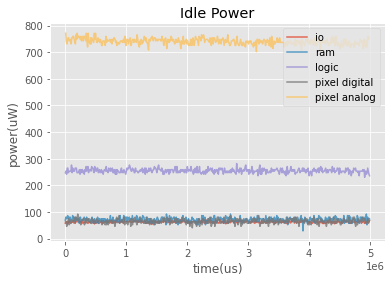

In [10]:
if timestamp_all_zero:
    
    print("timestamps are all zeros, can't plot power vs. time, you might need to update the firmware!")
    
else:
    
    # plot the output neuron index vs. time
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    p_track_name = ["io", "ram", "logic", "pixel digital", "pixel analog"]
    for p_track_id in range(num_power_tracks):
        x = [each.timestamp for each in power_events if each.channel == p_track_id]
        y = [each.value * 1e6 for each in power_events if each.channel == p_track_id]
        plt.plot(x, y, label=p_track_name[p_track_id], alpha=0.8)
        
    ax.set_xlabel("time(us)")
    ax.set_ylabel("power(uW)")
    ax.set_title("Idle Power")
    ax.legend(loc="upper right", fontsize=10)

In [11]:
# close devkit after experiment finished
samna.device.close_device(devkit)

## 3. Monitor the dynamic power

In this section we introduce the way to monitor the dynamic power of the devkit i.e. the power after we deploy an SNN on it.

Also, we introduce a GUI module of samna which helps to monitor the real-time power plot.


![real_time_power_plot](../../_static/power_monitoring/power_plot.png)

### 3.1 Create a simple SNN

In [12]:
# create a one layer CNN
input_shape = (1, 128, 128)

cnn = nn.Sequential(nn.Conv2d(in_channels=1,
                              out_channels=1,
                              kernel_size=(1, 1),
                              stride=(2, 2),
                              padding=(0, 0),
                              bias=False),
                    nn.ReLU())

# assign a handcraft weight to CNN
cnn[0].weight.data = torch.ones_like(cnn[0].weight.data, dtype=torch.float32) * 0.05

In [13]:
# cnn to snn
snn = from_model(cnn, input_shape=input_shape, batch_size=1).spiking_model

# snn to DynapcnnNetwork
dynapcnn_net = DynapcnnNetwork(snn=snn, input_shape=input_shape, dvs_input=True)

### 3.2 Create a devkit config based on the SNN

In [14]:
dynapcnn_device_str = "speck2edevkit:0"
devkit_cfg = dynapcnn_net.make_config(device=dynapcnn_device_str, monitor_layers=["dvs"])

Network is valid


### 3.3 Construct a samna graph for power monitoring & visualization

![dynamic_power_graph](../../_static/power_monitoring/dynamic_power_samna_graph.png)

In [15]:
# get device name
devices = samna.device.get_all_devices()
device_names = [each.device_type_name for each in devices]
device_names

# open devkit
devkit = samna.device.open_device(device_names[0])

# get the handle of the stop-watch of the devkit
stop_watch = devkit.get_stop_watch()

# reset the stop-watch of devkit
# stop_watch = devkit.get_stop_watch()
# stop_watch.set_enable_value(True)
# stop_watch.reset()
# time.sleep(0.01)

# get the handle of the power monitor of the devkit
power_monitor = devkit.get_power_monitor()

# create samna node for power reading
power_source_node = power_monitor.get_source_node()
power_buffer_node = samna.BasicSinkNode_unifirm_modules_events_measurement()

# init samna graph
samna_graph = samna.graph.EventFilterGraph()


'''
=====  construct branches in the graph to define how data flows  =====
'''
# branch #1: DVS data visualization on GUI
_, _, streamer = samna_graph.sequential([devkit.get_model_source_node(), "Speck2eDvsToVizConverter", "VizEventStreamer"])

# branch #2: Collect power data
samna_graph.sequential([power_source_node, power_buffer_node])

# branch #3: Real time power data visualization on GUI
samna_graph.sequential([power_source_node, "MeasurementToVizConverter", streamer])

# define tcp port for data visualization
streamer_endpoint = 'tcp://0.0.0.0:40000' 
streamer.set_streamer_endpoint(streamer_endpoint)

# start the samna graph 
samna_graph.start()

True

### 3.4 Setup the GUI visualizer of samna

In [16]:
# init samna node for tcp communication
samna_node = samna.init_samna()
sender_endpoint = samna_node.get_sender_endpoint()
receiver_endpoint = samna_node.get_receiver_endpoint()
# wait tcp connection build up, this is necessary to open remote node.
time.sleep(1.0)

sender_endpoint: tcp://0.0.0.0:59073
receiver_endpoint: tcp://0.0.0.0:60313


In [17]:
# define a function that start the gui visualizer then we run it in the sub-process
def run_visualizer_process(receiver_endpoint, sender_endpoint, visualizer_id):

    samnagui.runVisualizer(0.6, 0.6, receiver_endpoint, sender_endpoint, visualizer_id)

    return

In [18]:
# init sub-process for GUI
visualizer_id = 3
gui_process = Process(target=run_visualizer_process, args=(receiver_endpoint, sender_endpoint, visualizer_id))

# start the GUI process
gui_process.start()

# wait for open visualizer and connect to it.
timeout = 10
begin = time.time()
name = "visualizer" + str(visualizer_id)
while time.time() - begin < timeout:

    try:

        time.sleep(0.05)
        samna.open_remote_node(visualizer_id, name)

    except:

        continue

    else:
        print("Successfully start the GUI process! You should see a window pop up")
        break


Successfully start the GUI process! You should see a window pop up


In [19]:
# setup visualizer
visualizer = getattr(samna, name)


# set visualizer's receiver endpoint to streamer's sender endpoint
visualizer.receiver.set_receiver_endpoint(streamer_endpoint)
# connect the receiver output to splitter inside the visualizer
visualizer.receiver.add_destination(visualizer.splitter.get_input_channel())

# add DVS plots to gui
activity_plot_id = visualizer.plots.add_activity_plot(128, 128, "DVS Layer")
plot = visualizer.plot_0
plot.set_layout(0, 0, 0.5, 0.89)
visualizer.splitter.add_destination("dvs_event", visualizer.plots.get_plot_input(activity_plot_id))

# add real time power plots to gui
power_plot_id = visualizer.plots.add_power_measurement_plot("power consumption", 5, ["io", "ram", "logic", "vddd", "vdda"])
plot_name = "plot_" + str(power_plot_id)
plot = getattr(visualizer, plot_name)
plot.set_layout(0, 0.75, 1.0, 1.0)
plot.set_show_x_span(10)
plot.set_label_interval(2)
plot.set_max_y_rate(1.5)
plot.set_show_point_circle(False)
plot.set_default_y_max(1)
plot.set_y_label_name("power (mW)")  # set the label of y axis
visualizer.splitter.add_destination("measurement", visualizer.plots.get_plot_input(power_plot_id))

visualizer.plots.report()

print("Now you should see a change on the GUI window!")

Now you should see a change on the GUI window!


### 3.5 Apply devkit config and launch the devit

In [20]:
# apply devkit config
devkit.get_model().apply_configuration(devkit_cfg)
time.sleep(0.1)

print("Now you should see the input from the dvs sensor on the GUI window!" )

Now you should see the input from the dvs sensor on the GUI window!


### 3.6 Start to monitor dynamic power

In [21]:
sample_rate = 100
power_monitor.start_auto_power_measurement(sample_rate)

print("Now you should see the real-time power plot shows on the GUI window!")

Now you should see the real-time power plot shows on the GUI window!


In [22]:
# stop the experiment
gui_process.terminate()
gui_process.join()

samna_graph.stop()
samna.device.close_device(devkit)